In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_original_data():
    return pd.read_excel("Data/Data_MidTerm_Project_Real_State_Regression.xls" )

In [3]:
def clean_data(df):
    df=df.dropna()
    ## droping columns
    df=df.drop(columns=['id','view','lat','long','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'])
    ## removing duplicates
    df=df.drop_duplicates()
    #date changed to dd/mm/year format
    df['date'] = df['date'].dt.strftime('%Y')
    #changing price values to currency format
    df['price'] = df['price'].apply(lambda x: "{:.2f}".format((x/1000)))
    df['price'] = df['price'].astype(float)
    return df

In [5]:
re_df=load_original_data()
re_df=clean_data(re_df)

In [6]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          21597 non-null  object 
 1   bedrooms      21597 non-null  int64  
 2   bathrooms     21597 non-null  float64
 3   sqft_living   21597 non-null  int64  
 4   sqft_lot      21597 non-null  int64  
 5   floors        21597 non-null  float64
 6   waterfront    21597 non-null  int64  
 7   condition     21597 non-null  int64  
 8   grade         21597 non-null  int64  
 9   yr_built      21597 non-null  int64  
 10  yr_renovated  21597 non-null  int64  
 11  zipcode       21597 non-null  int64  
 12  price         21597 non-null  float64
dtypes: float64(3), int64(9), object(1)
memory usage: 2.3+ MB


In [7]:
re_df.shape

(21597, 13)

### Plotting

Plot the distribution of price vs. number of bedrooms, price vs. number of bathrooms, price vs. condition, price vs. floors, price vs. grade, price vs. view, and price vs. waterfront.

State your observation for each one of those graphs. 
Do you see any trends in prices vs the rest of those variables individually? This can also be used for EDA to identify some data cleaning operations that you might need to perform further.

In [8]:
re_df[['condition','grade','yr_built','yr_renovated','zipcode']] = re_df[['condition','grade','yr_built','yr_renovated','zipcode']].astype(str)
# converting categorical columns

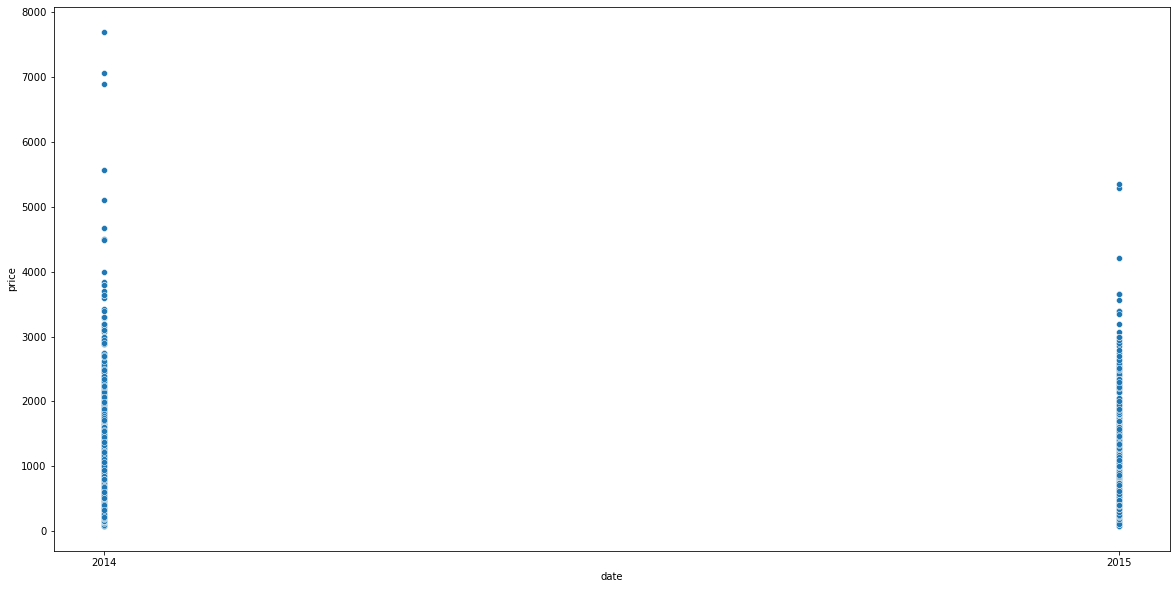

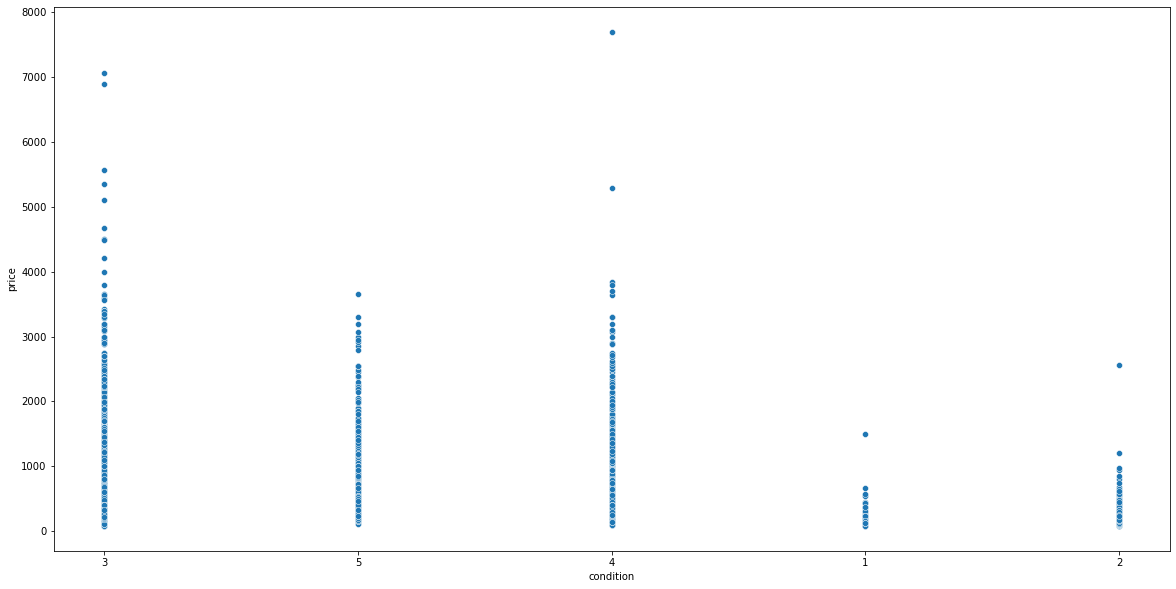

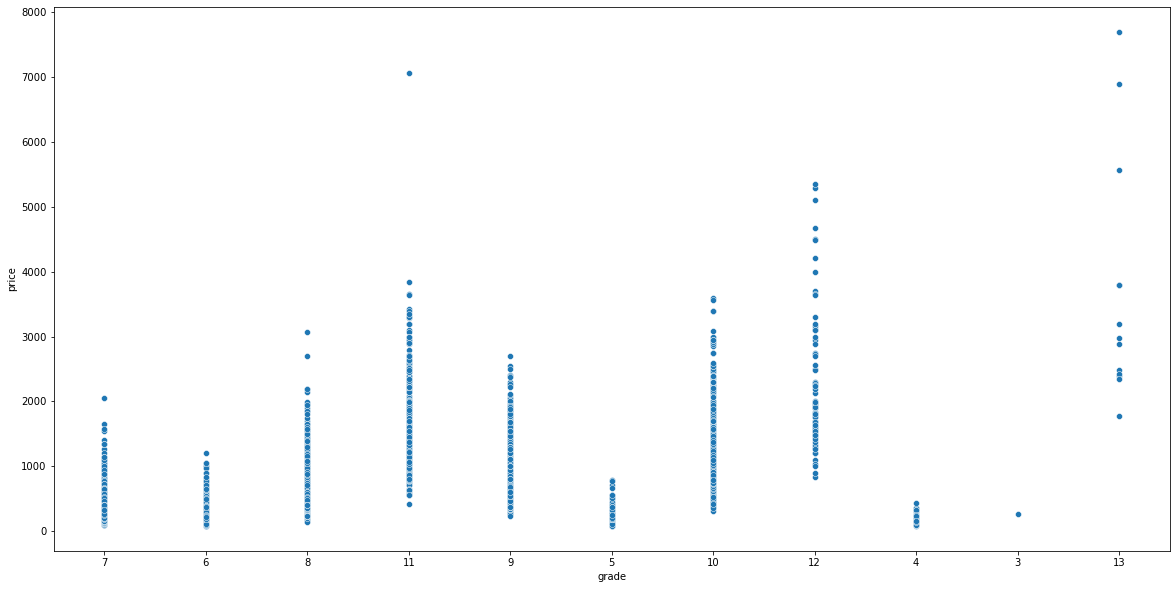

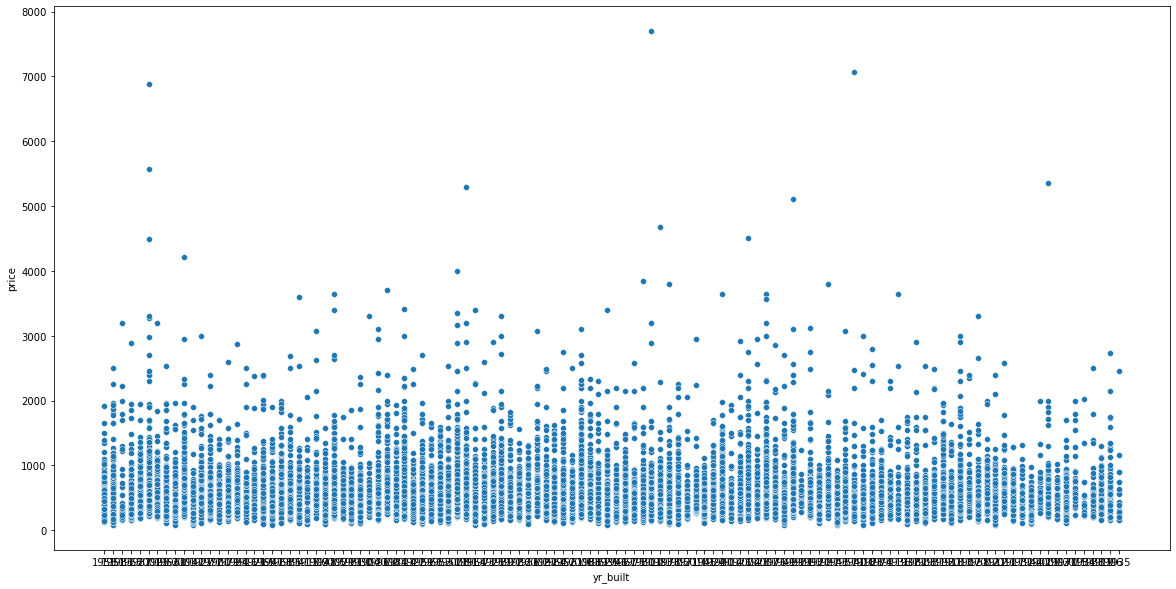

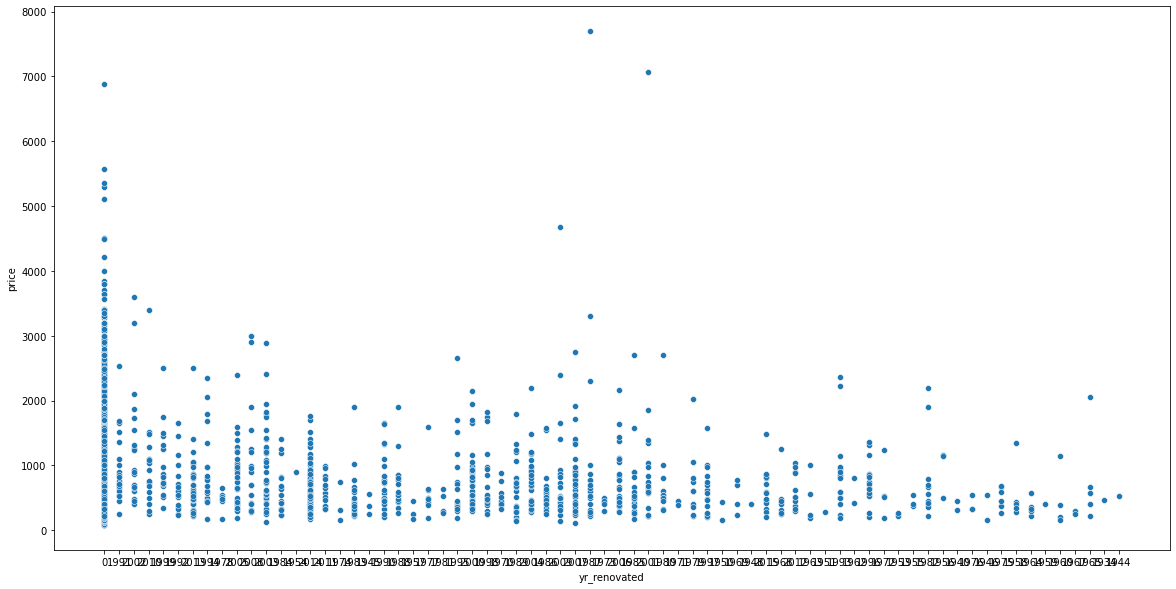

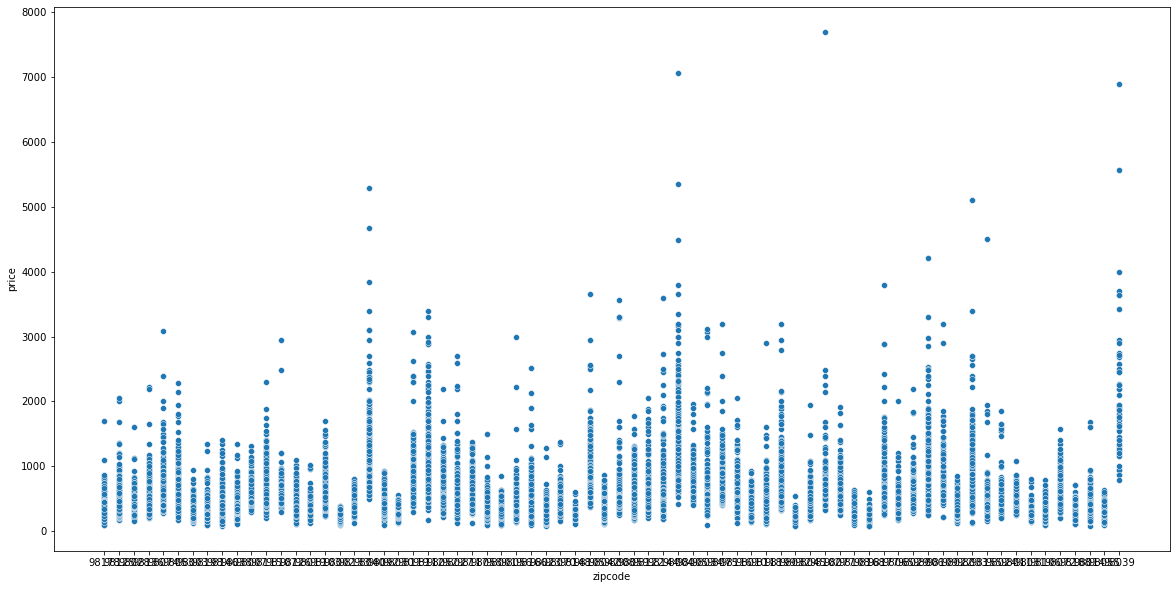

In [9]:
for c in re_df.select_dtypes(object):
    plt.figure(figsize=(20,10))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

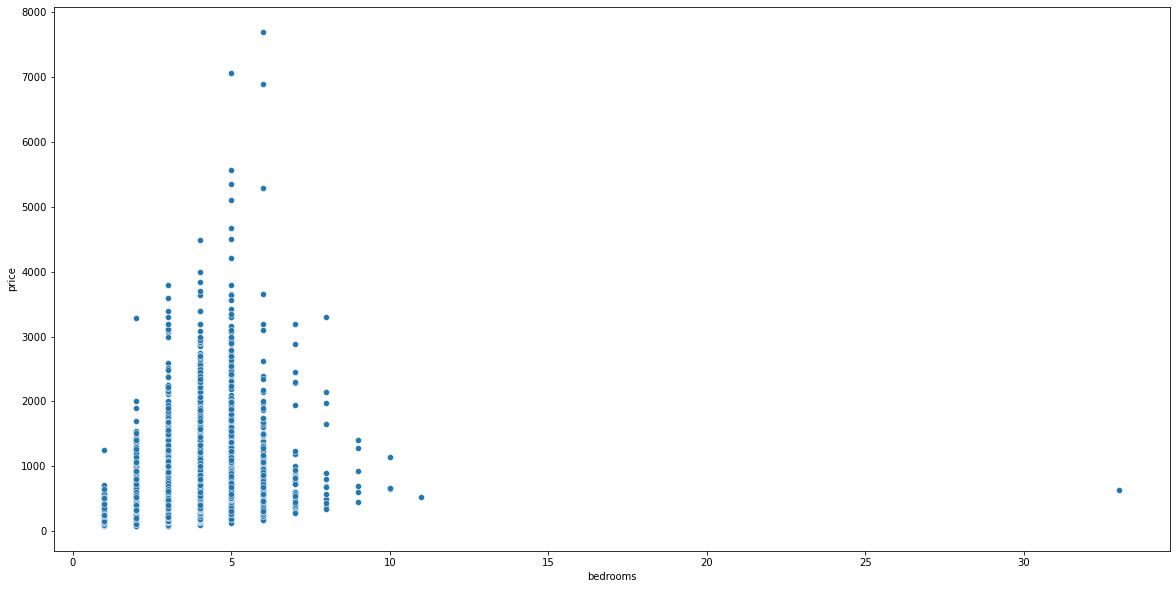

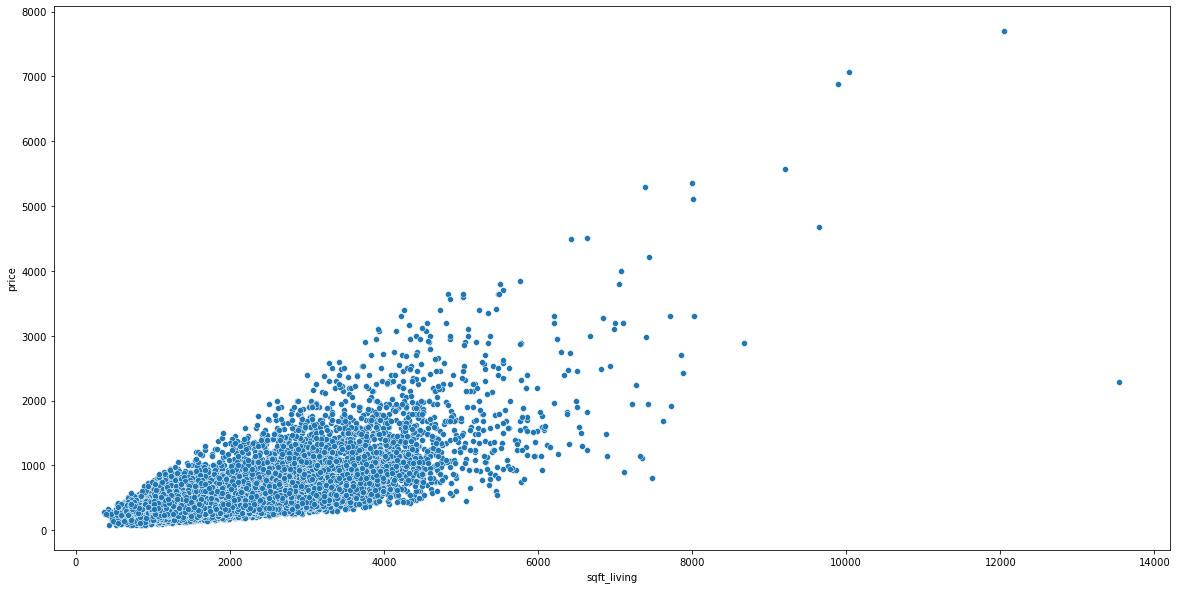

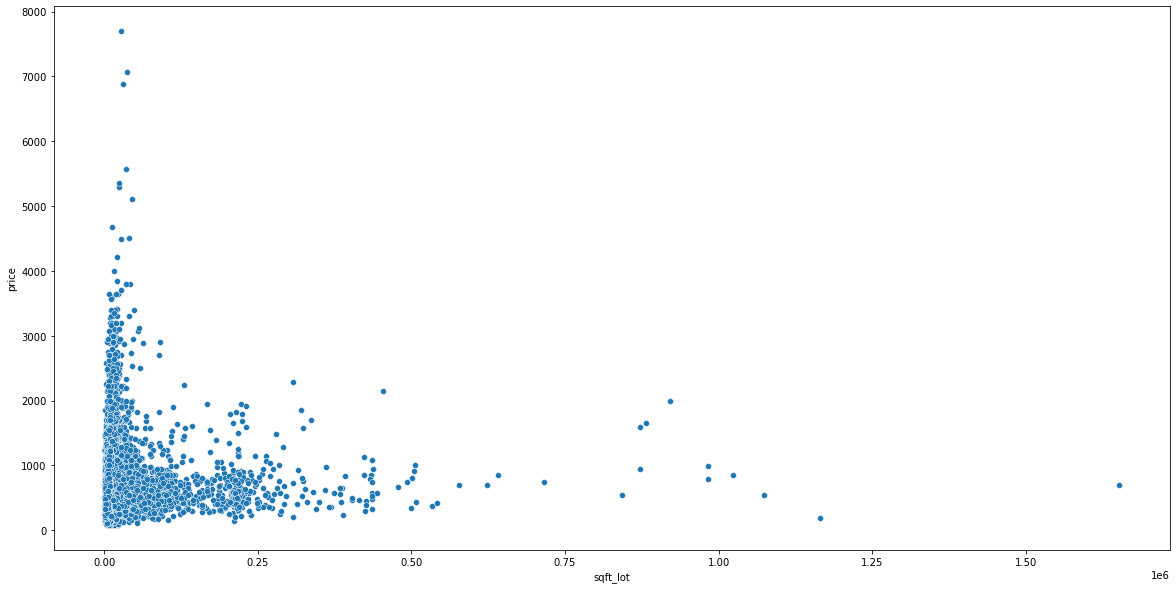

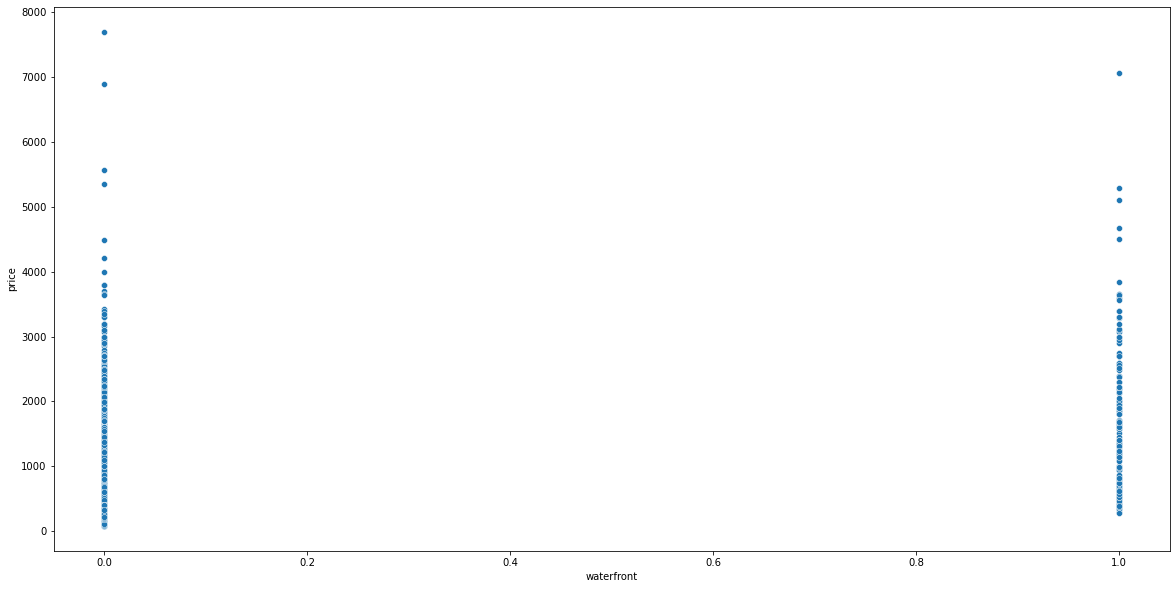

In [10]:
for c in re_df.select_dtypes(int):
    plt.figure(figsize=(20,10))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

## removing outliers

<AxesSubplot:xlabel='sqft_living'>

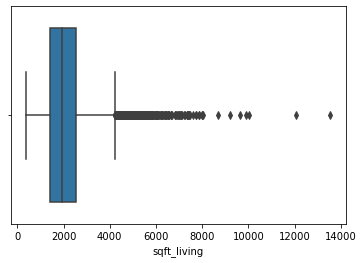

In [12]:
sns.boxplot(re_df.sqft_living)

In [13]:
Q1 = re_df.sqft_living.quantile(0.25)
Q3 = re_df.sqft_living.quantile(0.75) 
IQR = Q3 - Q1

filter = (re_df['sqft_living'] >= Q1 - 1.5 * IQR) & (re_df['sqft_living'] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]

<AxesSubplot:>

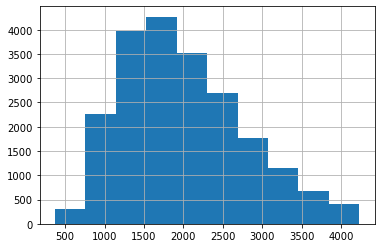

In [14]:
re_df.sqft_living.hist()

<AxesSubplot:xlabel='sqft_lot'>

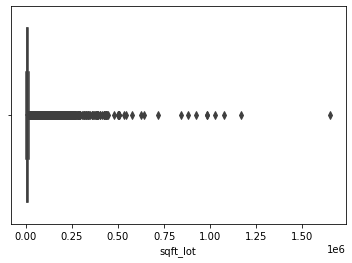

In [15]:
sns.boxplot(re_df.sqft_lot)

In [16]:
Q1 = re_df.sqft_lot.quantile(0.25)
Q3 = re_df.sqft_lot.quantile(0.75)
IQR = Q3 - Q1
filter = (re_df['sqft_lot'] >= Q1 - 1.5 * IQR) & (re_df['sqft_lot'] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]

<AxesSubplot:>

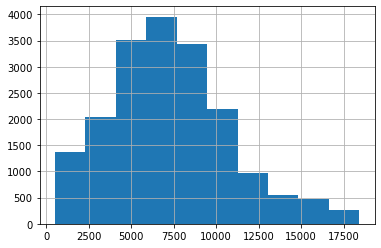

In [17]:
re_df.sqft_lot.hist()

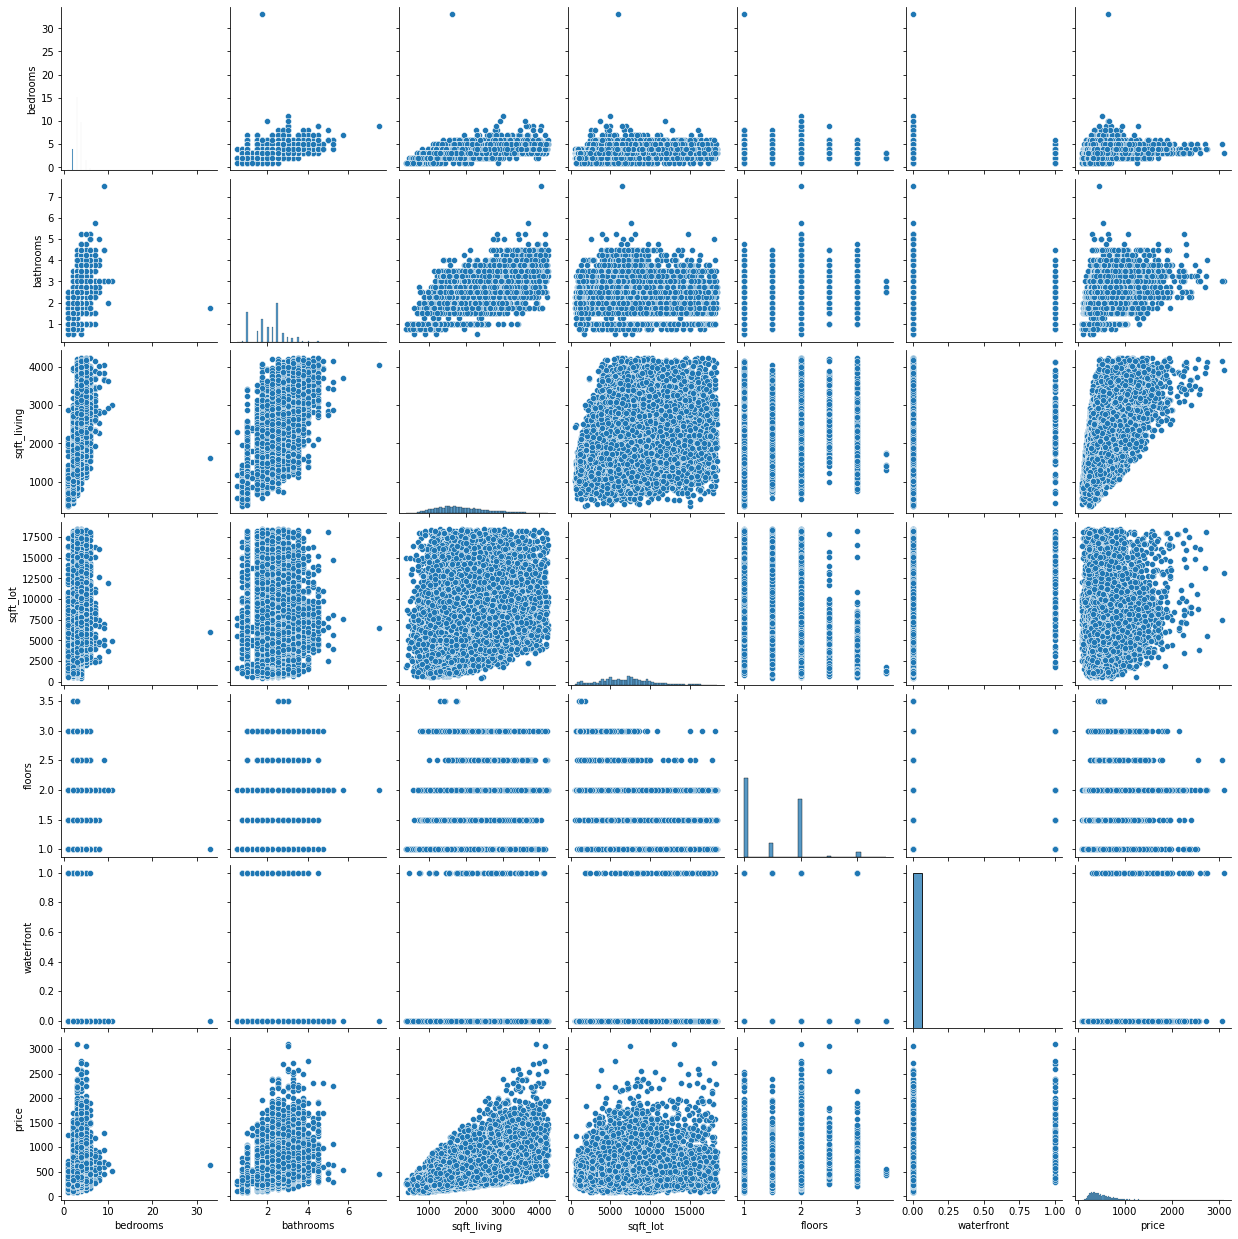

In [18]:
sns.pairplot(re_df)
plt.show()

## Data transformation

In [19]:
sqft_living_transformed,lam=boxcox(re_df['sqft_living'])

<AxesSubplot:ylabel='Count'>

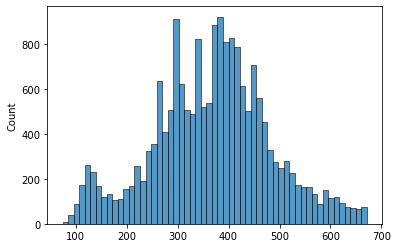

In [20]:
sqft_lot_transformed,lam=boxcox(re_df['sqft_lot'])
sns.histplot(sqft_lot_transformed)

<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

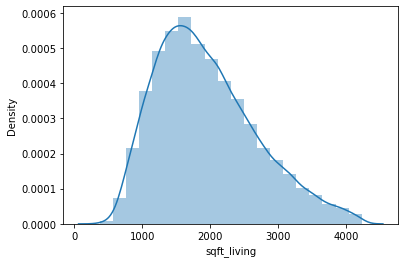

In [21]:
sns.distplot((re_df['sqft_living']), bins=20)

<AxesSubplot:xlabel='sqft_lot', ylabel='Density'>

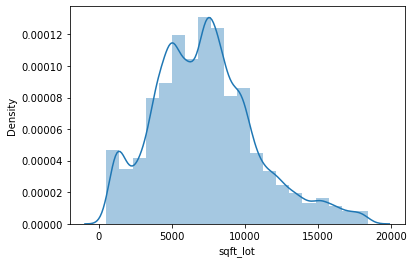

In [22]:
sns.distplot((re_df['sqft_lot']), bins=20)

In [23]:
#checking correlation
numericals_features=re_df._get_numeric_data()
correlations = numericals_features.corr()
correlations

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,price
bedrooms,1.000000,0.490504,0.599036,0.195430,0.155339,-0.011269,0.276310
bathrooms,0.490504,1.000000,0.718902,-0.003743,0.514034,0.017822,0.442074
sqft_living,0.599036,0.718902,1.000000,0.231304,0.346256,0.042765,0.621203
sqft_lot,0.195430,-0.003743,0.231304,1.000000,-0.340026,0.066250,0.054232
floors,0.155339,0.514034,0.346256,-0.340026,1.000000,0.017539,0.255321
waterfront,-0.011269,0.017822,0.042765,0.066250,0.017539,1.000000,0.188983
price,0.276310,0.442074,0.621203,0.054232,0.255321,0.188983,1.000000


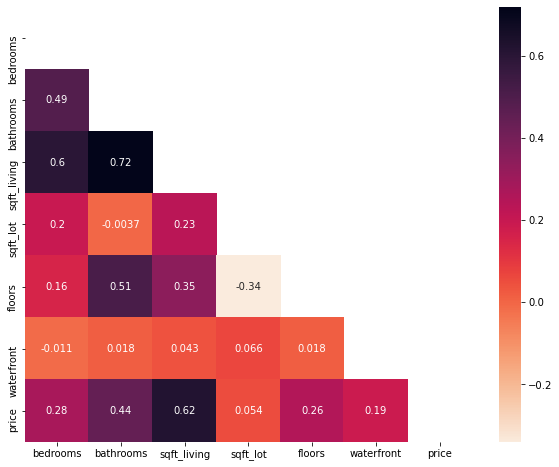

In [24]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(numericals_features.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(numericals_features.corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

In [25]:
#XY Split
x=re_df.drop('price', axis=1)
y=re_df.price

In [26]:
x

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode
0,2014,3,1.00,1180,5650,1.0,0,3,7,1955,0,98178
1,2014,3,2.25,2570,7242,2.0,0,3,7,1951,1991,98125
2,2015,2,1.00,770,10000,1.0,0,3,6,1933,0,98028
3,2014,4,3.00,1960,5000,1.0,0,5,7,1965,0,98136
4,2015,3,2.00,1680,8080,1.0,0,3,8,1987,0,98074
...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014,3,2.50,1530,1131,3.0,0,3,8,2009,0,98103
21593,2015,4,2.50,2310,5813,2.0,0,3,8,2014,0,98146
21594,2014,2,0.75,1020,1350,2.0,0,3,7,2009,0,98144
21595,2015,3,2.50,1600,2388,2.0,0,3,8,2004,0,98027


In [27]:
numericals_features =x._get_numeric_data()
# numericals =data.select_dtypes(np.number)
numericals_features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
0,3,1.00,1180,5650,1.0,0
1,3,2.25,2570,7242,2.0,0
2,2,1.00,770,10000,1.0,0
3,4,3.00,1960,5000,1.0,0
4,3,2.00,1680,8080,1.0,0
...,...,...,...,...,...,...
21592,3,2.50,1530,1131,3.0,0
21593,4,2.50,2310,5813,2.0,0
21594,2,0.75,1020,1350,2.0,0
21595,3,2.50,1600,2388,2.0,0


In [28]:
numericals_features.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
count,18771.000000,18771.000000,18771.000000,18771.000000,18771.000000,18771.000000
mean,3.328912,2.049917,1941.588141,7264.032337,1.484151,0.003889
std,0.912276,0.713505,740.290170,3502.526355,0.544505,0.062242
min,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000
25%,3.000000,1.500000,1380.000000,4838.500000,1.000000,0.000000
50%,3.000000,2.000000,1830.000000,7200.000000,1.000000,0.000000
75%,4.000000,2.500000,2400.000000,9282.000000,2.000000,0.000000
max,33.000000,7.500000,4230.000000,18414.000000,3.500000,1.000000


In [29]:
#Get Categorical data

categoricals_features = x.select_dtypes(object)
categoricals_features

,date,condition,grade,yr_built,yr_renovated,zipcode
0,2014,3,7,1955,0,98178
1,2014,3,7,1951,1991,98125
2,2015,3,6,1933,0,98028
3,2014,5,7,1965,0,98136
4,2015,3,8,1987,0,98074
...,...,...,...,...,...,...
21592,2014,3,8,2009,0,98103
21593,2015,3,8,2014,0,98146
21594,2014,3,7,2009,0,98144
21595,2015,3,8,2004,0,98027


In [30]:
# get dummies pandas
categoricals_features=pd.get_dummies(categoricals_features, drop_first=True)
categoricals_features

,date_2015,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
all_features=pd.concat([numericals_features, categoricals_features], axis=1) 
# concat numerical and categorical transformations
all_features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,date_2015,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,3,1.00,

In [32]:
#train test split

x_train, x_test, y_train, y_test=train_test_split(all_features, y, test_size=.20, random_state=100)

In [33]:
x_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,date_2015,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
2813,4,1.

In [34]:
# Standardize
std_scaler=StandardScaler().fit(x_train) 

x_train_scaled=std_scaler.transform(x_train)

In [35]:
x_test_scaled=std_scaler.transform(x_test)

In [36]:
len(x_train_scaled[1])

272

In [37]:
# Modelling without scaling

x_train_const= sm.add_constant(x_train) # adding a constant

model = sm.OLS(y_train, x_train_const).fit()
predictions_train = model.predict(x_train_const) 

x_test_const = sm.add_constant(x_test) # adding a constant
predictions_test = model.predict(x_test_const) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     261.6
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:45:21   Log-Likelihood:                -92297.
No. Observations:               15016   AIC:                         1.851e+05
Df Residuals:                   14743   BIC:                         1.872e+05
Df Model:                         272                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               140.2918     35.92

In [38]:
model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[1:].index.tolist()

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'date_2015',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_11',
 'grade_12',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'yr_built_1901',
 'yr_built_1903',
 'yr_built_1908',
 'yr_built_1943',
 'yr_built_1951',
 'yr_built_1952',
 'yr_built_1953',
 'yr_built_1954',
 'yr_built_1955',
 'yr_built_1957',
 'yr_built_1958',
 'yr_built_1959',
 'yr_built_1960',
 'yr_built_1961',
 'yr_built_1962',
 'yr_built_1963',
 'yr_built_1964',
 'yr_built_1965',
 'yr_built_1966',
 'yr_built_1967',
 'yr_built_1968',
 'yr_built_1969',
 'yr_built_1970',
 'yr_built_1971',
 'yr_built_1972',
 'yr_built_1973',
 'yr_built_1974',
 'yr_built_1975',
 'yr_built_1976',
 'yr_built_1977',
 'yr_built_1978',
 'yr_built_1979',
 'yr_built_1980',
 'yr_built_1982',
 'yr_built_1984',
 'yr_built_1985',
 'yr_built_1986',
 'yr_built_1987',
 'yr_built_1988',
 'yr_built_1989',
 'yr_built_1990',
 'y

In [39]:
significant_features=all_features[model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[1:].index.tolist()]

In [40]:
#with scaling

x_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'date_2015', 'condition_2', 'condition_3', 'condition_4',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=272)

x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant

model = sm.OLS(y_train,x_train_const_scaled).fit()
predictions_train = model.predict(x_train_const_scaled) 

y_pred=model.predict(x_test_scaled)

x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant
predictions_test = model.predict(x_test_const_scaled) 
print_model = model.summary()
print(print_model)

In [42]:
model=LinearRegression()    # model
model.fit(x_train_scaled, y_train)   # model train

y_pred=model.predict(x_test_scaled)   # model prediction


y_pred_train=model.predict(x_train_scaled)

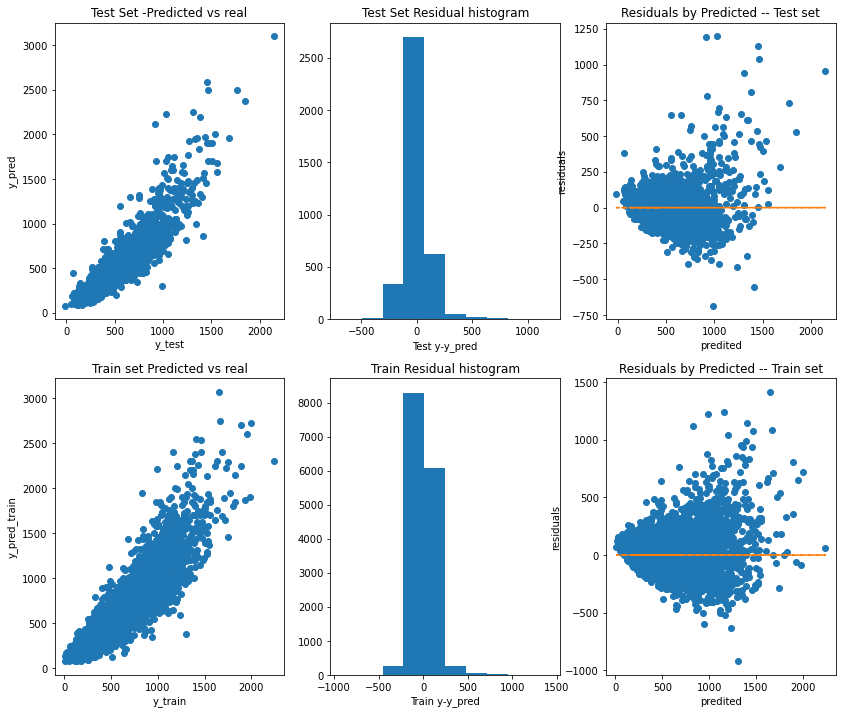

In [43]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(2,3,figsize=(14,12))
ax[0,0].plot(y_pred, y_test, 'o')
ax[0,0].set_xlabel("y_test")
ax[0,0].set_ylabel("y_pred")
ax[0,0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[0,1].hist(y_test - y_pred)
ax[0,1].set_xlabel("Test y-y_pred")
ax[0,1].set_title("Test Set Residual histogram")

ax[0,2].plot(y_pred,y_test - y_pred,"o")
ax[0,2].set_xlabel("predited")
ax[0,2].set_ylabel("residuals")
ax[0,2].set_title("Residuals by Predicted -- Test set")
ax[0,2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')


ax[1,0].plot(y_pred_train, y_train, 'o')
ax[1,0].set_xlabel("y_train")
ax[1,0].set_ylabel("y_pred_train")
ax[1,0].set_title("Train set Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1,1].hist(y_train - y_pred_train)
ax[1,1].set_xlabel("Train y-y_pred")
ax[1,1].set_title("Train Residual histogram")

ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
ax[1,2].set_xlabel("predited")
ax[1,2].set_ylabel("residuals")
ax[1,2].set_title("Residuals by Predicted -- Train set")
ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')

In [44]:
R2_train=r2_score(y_train,y_pred_train)
R2_test=r2_score(y_test,y_pred)

print (R2_train)
print(R2_test)

0.828367051450208
0.8208485531558022


In [45]:
#MSE
train_mse=mse(y_train,y_pred_train)
test_mse=mse(y_test,y_pred)

print ('train MSE: {} -- test MSE: {}'.format(train_mse, test_mse))

train MSE: 12774.708526276147 -- test MSE: 13545.937182365145


In [46]:
#RSME
print ('train RMSE: {} -- test RMSE: {}'.format(train_mse**.5, test_mse**.5))

train RMSE: 113.02525614337773 -- test RMSE: 116.38701466385821


In [47]:
#MAE

train_mae=mae(y_train,y_pred_train)
test_mae=mae(y_test,y_pred)

print ('train MAE: {} -- test MAE: {}'.format(train_mse, test_mse))

train MAE: 12774.708526276147 -- test MAE: 13545.937182365145


In [48]:
Adj_R2_train= 1 - (1-R2_train)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
Adj_R2_train

0.8252005207572999

In [49]:
Adj_R2_test= 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
Adj_R2_test

0.8068539542064564